<a href="https://colab.research.google.com/github/mbeisen/Berrocal_2020/blob/main/RetrosheetRuns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
import requests
import zipfile
from collections import Counter

import itertools
import random


In [2]:
def split_consecutive_groups(lst):
    return [list(group) for key, group in itertools.groupby(lst)]

### Get Retrosheet game Logs if not already downloaded

In [3]:
target_folder = "data/retrosheet/gamelogs/"

url = "https://www.retrosheet.org/gamelogs/gl1871_2023.zip"

# make directory is it doesn't exist

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

filename = url.split('/')[-1]
file_path = os.path.join(target_folder, filename)
unzip_path = os.path.join(target_folder, os.path.splitext(filename)[0])

if not os.path.exists(unzip_path):
    # Download the file
    print(f"Downloading {filename}...")
    response = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(response.content)

    # Unzip the file
    print(f"Unzipping {filename}...")
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        zip_ref.extractall(unzip_path)

    print(f"File unzipped at {unzip_path}")
else:
    print(f"{filename} has already been downloaded and unzipped.")

gamelog_dir = unzip_path


Unzipping gl1871_2023.zip...
File unzipped at data/retrosheet/gamelogs/gl1871_2023


In [4]:
def parse_individual_linescore(linescore):

    # This function will parse an individual linescore like "00102(11)000"
    # and return a numpy array

    # replace misc characters with 0

    linescore = linescore.replace('x','0')
    linescore = linescore.replace('.','0')
    linescore = linescore.replace('n','0')


    scores = []
    i = 0

    # probably a more elegant way to do this with regular expression

    while i < len(linescore):
        if linescore[i] == '(':
            # Find the closing parenthesis
            close_paren = linescore.find(')', i)
            # Extract the number within parentheses
            score = int(linescore[i + 1:close_paren])
            i = close_paren + 1
        else:
            # Handle single digit score
            try:
              score = int(linescore[i])
            except:
              score = 0
            i += 1
        scores.append(score)
    #random.shuffle(scores)
    return scores

def sum_linescore(nls):
    return np.sum(nls)


In [5]:
retrosheet_headers = [
    "date", "game_number", "day_of_week",
    "visitor_team", "visitor_league", "visitor_game_number",
    "home_team", "home_league", "home_game_number",
    "visitor_score", "home_score", "length_of_game_outs",
    "day_night", "completion_info", "forfeit_info",
    "protest_info", "park_id", "attendance",
    "time_of_game_minutes", "visitor_line_score", "home_line_score",
    "visitor_at_bats", "visitor_hits", "visitor_doubles",
    "visitor_triples", "visitor_home_runs", "visitor_RBI",
    "visitor_sacrifice_hits", "visitor_sacrifice_flies", "visitor_hit_by_pitch",
    "visitor_walks", "visitor_intentional_walks", "visitor_strikeouts",
    "visitor_stolen_bases", "visitor_caught_stealing",
    "visitor_gidp","visitor_catcherint","visitor_left_on_base",
    "visitor_pitchers_used", "visitor_individual_earned_runs", "visitor_team_earned_runs",
    "visitor_wild_pitches", "visitor_balks", "visitor_putouts",
    "visitor_assists", "visitor_errors", "visitor_passed_balls",
    "visitor_double_plays", "visitor_triple_plays",
    "home_at_bats", "home_hits", "home_doubles",
    "home_triples", "home_home_runs", "home_RBI",
    "home_sacrifice_hits", "home_sacrifice_flies", "home_hit_by_pitch",
    "home_walks", "home_intentional_walks", "home_strikeouts",
    "home_stolen_bases", "home_caught_stealing",
    "home_gidp","home_catcherint","home_left_on_base",
    "home_pitchers_used", "home_individual_earned_runs", "home_team_earned_runs",
    "home_wild_pitches", "home_balks", "home_putouts",
    "home_assists", "home_errors", "home_passed_balls",
    "home_double_plays", "home_triple_plays",
    "home_plate_umpire_id", "home_plate_umpire_name",
    "first_base_umpire_id", "first_base_umpire_name",
    "second_base_umpire_id", "second_base_umpire_name",
    "third_base_umpire_id", "third_base_umpire_name",
    "left_field_umpire_id", "left_field_umpire_name",
    "right_field_umpire_id", "right_field_umpire_name",
    "visitor_manager_id", "visitor_manager_name",
    "home_manager_id", "home_manager_name",
    "winning_pitcher_id", "winning_pitcher_name",
    "losing_pitcher_id", "losing_pitcher_name",
    "saving_pitcher_id", "saving_pitcher_name",
    "game_winning_rbi_batter_id", "game_winning_rbi_batter_name",
    "visitor_starting_pitcher_id", "visitor_starting_pitcher_name",
    "home_starting_pitcher_id", "home_starting_pitcher_name",
    "visitor_batter_1_id", "visitor_batter_1_name", "visitor_batter_1_position",
    "visitor_batter_2_id", "visitor_batter_2_name", "visitor_batter_2_position",
    "visitor_batter_3_id", "visitor_batter_3_name", "visitor_batter_3_position",
    "visitor_batter_4_id", "visitor_batter_4_name", "visitor_batter_4_position",
    "visitor_batter_5_id", "visitor_batter_5_name", "visitor_batter_5_position",
    "visitor_batter_6_id", "visitor_batter_6_name", "visitor_batter_6_position",
    "visitor_batter_7_id", "visitor_batter_7_name", "visitor_batter_7_position",
    "visitor_batter_8_id", "visitor_batter_8_name", "visitor_batter_8_position",
    "visitor_batter_9_id", "visitor_batter_9_name", "visitor_batter_9_position",
    "home_batter_1_id", "home_batter_1_name", "home_batter_1_position",
    "home_batter_2_id", "home_batter_2_name", "home_batter_2_position",
    "home_batter_3_id", "home_batter_3_name", "home_batter_3_position",
    "home_batter_4_id", "home_batter_4_name", "home_batter_4_position",
    "home_batter_5_id", "home_batter_5_name", "home_batter_5_position",
    "home_batter_6_id", "home_batter_6_name", "home_batter_6_position",
    "home_batter_7_id", "home_batter_7_name", "home_batter_7_position",
    "home_batter_8_id", "home_batter_8_name", "home_batter_8_position",
    "home_batter_9_id", "home_batter_9_name", "home_batter_9_position",
    "additional_info", "acquisition_info"
]

In [8]:
# Load single year game logs

# using generic column names but should import from rs

rs_gls = []

for y in np.arange(2000,2024):
    rs_gls.append(pd.read_csv(gamelog_dir + "/gl%d.txt" % y, dtype = 'str', names = retrosheet_headers))

# combine into one dataframe
rs_gls = pd.concat(rs_gls).reset_index()

# create game id
rs_gls['game_id'] = rs_gls.home_team + "_" + rs_gls.date + "_" + rs_gls.game_number

# create integer season field
rs_gls['season'] = rs_gls['date'].apply(lambda x: int(x[0:4]))

# convert string linescore to np array
rs_gls['vls'] = rs_gls['visitor_line_score'].apply(parse_individual_linescore)
rs_gls['hls'] = rs_gls['home_line_score'].apply(parse_individual_linescore)

# calculate final score from linescore
rs_gls['vsc'] = rs_gls['vls'].apply(sum_linescore)
rs_gls['hsc'] = rs_gls['hls'].apply(sum_linescore)

# calculate innings from line score to ensure match
rs_gls['vll'] = rs_gls['vls'].apply(lambda x: len(x))
rs_gls['hll'] = rs_gls['hls'].apply(lambda x: len(x))

# throw out ties
rs_gls = rs_gls[rs_gls.vsc != rs_gls.hsc].copy()

# create columns with winning and losing score
rs_gls['wsc'] = rs_gls[['vsc','hsc']].max(axis=1)
rs_gls['lsc'] = rs_gls[['vsc','hsc']].min(axis=1)

# remove games where linescore lengths don't match
rs_gls = rs_gls[rs_gls.hll == rs_gls.vll]

# make sure complete game
rs_gls = rs_gls[rs_gls.acquisition_info == "Y"]

# only games 9 innings or longer
rs_gls = rs_gls[rs_gls["length_of_game_outs"].astype('int') >= 51]

In [9]:
# Game stats

game_stats = pd.DataFrame(columns=['Stat','Value']).set_index('Stat')
ngames = len(rs_gls)
game_stats.loc['nGames','Value'] = len(rs_gls)
game_stats.loc['Home win %','Value'] = len(rs_gls[rs_gls.hsc > rs_gls.vsc]) / game_stats.loc['nGames'].Value
game_stats.loc['Away win %','Value'] = len(rs_gls[rs_gls.vsc > rs_gls.hsc]) / game_stats.loc['nGames'].Value
hruns = rs_gls['hsc'].astype('int').sum()
vruns = rs_gls['vsc'].astype('int').sum()
game_stats.loc['Home run %','Value'] = hruns / (hruns + vruns)
game_stats.loc['Away run %','Value'] = vruns / (hruns + vruns)
wruns = rs_gls['wsc'].astype('int').sum()
lruns = rs_gls['lsc'].astype('int').sum()
game_stats.loc['Winner run %','Value'] = wruns / (wruns + lruns)
game_stats.loc['Loser run %','Value'] = lruns / (wruns + lruns)
game_stats.loc['Average Winning Runs','Value'] = wruns/ngames
game_stats.loc['Average Losing Runs','Value'] = lruns/ngames
game_stats.loc['Average Victory Margin','Value'] = (wruns - lruns)/ngames

In [10]:
game_stats

,Value
Stat,
nGames,56393
Home win %,0.538152
Away win %,0.461848
Home run %,0.50721
Away run %,0.49279
Winner run %,0.691015
Loser run %,0.308985
Average Winning Runs,6.311457
Average Losing Runs,2.822141


### Histogram of runs scored in inning by home and visitors

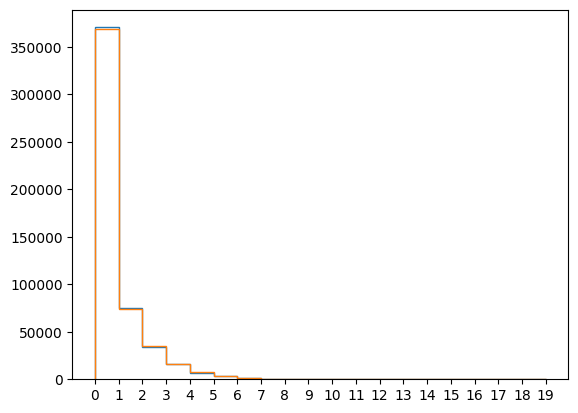

In [11]:
vscores = []
hscores = []

for i,r in rs_gls.iterrows():
    vscores.extend(r.vls[0:9])
    hscores.extend(r.hls[0:9])

b = np.arange(0,20)
plt.hist(vscores,bins=b,histtype='step')
plt.hist(hscores,bins=b,histtype='step')
plt.xticks(b)
print ()


In [12]:
# Parse out stats about individual runs

rundata = []
gameseqs = []

for i,r in rs_gls.iterrows():

    gameseq = []

    # who won game

    if r['vsc'] > r['hsc']:
      vw = 1
      hw = 0
    elif r['hsc'] > r['vsc']:
      vw = 0
      hw = 1
    else:
      vw = -1
      hw = -1

    # what was decisive run

    v = 0
    h = 0
    rl = []

    for j in np.arange(0,len(r['vls'])):
      for k in np.arange(0, r['vls'][j]):
        v += 1
        if v > h:
          rl.append('v')
        elif v < h:
          rl.append('h')
        else:
          rl.append('t')

      for k in np.arange(0, r['hls'][j]):
        h += 1
        if v > h:
          rl.append('v')
        elif v < h:
          rl.append('h')
        else:
          rl.append('t')

    for dr in range(0,len(rl))[::-1]:
      if rl[dr] != rl[-1]:
        break
    if (dr == 0) and (rl[0] == rl[-1]):
      dr = 1
    else:
      dr = dr+2

    rig = 1
    vr = 0
    hr = 0


    if rl[0] == 'v':
        fr = 0
    elif rl[0] == 'h':
        fr = 1
    else:
        fr = -1

    for j in np.arange(0,len(r['vls'])):
      for k in np.arange(rig, rig+r['vls'][j]):
        vr = vr + 1
        rundata.append([r.game_id,r.season,r.vsc,r.hsc,vr,hr,j+1,k,0,vw,dr,fr])
        gameseq.append(0)

      rig = rig + r['vls'][j]

      for k in np.arange(rig, rig+r['hls'][j]):
        hr = hr + 1
        rundata.append([r.game_id,r.season,r.vsc,r.hsc,vr,hr,j+1,k,1,hw,dr,fr])
        gameseq.append(1)

      rig = rig + r['hls'][j]

    gameseqs.append(gameseq)

rs_gls['gameseq'] = gameseqs

rundata = pd.DataFrame(data=rundata,columns=['gameid','season','vgs','hgs','vcs','hcs','inning','rig','team','wl','dr','fr'])
rundata = rundata[rundata.wl != -1]

# add column innings_e where innings 10+ are all 10
rundata['inning_e'] = rundata['inning'].apply(lambda x: min(x,10))

# runs remaining to be scored in game
rundata['vrr'] = rundata['vgs'] - rundata['vcs']
rundata['hrr'] = rundata['hgs'] - rundata['hcs']

# runs remaining separated by run-scoring team and non-run-scoring team
rundata['rsrr']  = rundata['vrr'] * (rundata['team'] == 0) + rundata['hrr'] * (rundata['team'] == 1)
rundata['nrsrr'] = rundata['vrr'] * (rundata['team'] == 1) + rundata['hrr'] * (rundata['team'] == 0)

# runs before current run
rundata['vrb'] = rundata['vcs'] - 1 * (rundata['team'] == 0)
rundata['hrb'] = rundata['hcs'] - 1 * (rundata['team'] == 1)

# runs before separated by run-scoring team and non-run-scoring team
rundata['rsrb']  = rundata['vrb'] * (rundata['team'] == 0) + rundata['hrb'] * (rundata['team'] == 1)
rundata['nrsrb'] = rundata['vrb'] * (rundata['team'] == 1) + rundata['hrb'] * (rundata['team'] == 0)

# lead after run scored
rundata['vlead'] = rundata['vcs'] - rundata['hcs']
rundata['hlead'] = rundata['hcs'] - rundata['vcs']
rundata['lead'] = (rundata['team'] == 0) * rundata['vlead'] + (rundata['team'] == 1) * rundata['hlead']

# lead before run scored
rundata['vleadb'] = rundata['vrb'] - rundata['hrb']
rundata['hleadb'] = rundata['hrb'] - rundata['vrb']
rundata['leadb'] = (rundata['team'] == 0) * rundata['vleadb'] + (rundata['team'] == 1) * rundata['hleadb']

# lead in subsequent runs
rundata['vleada'] = rundata['vrr'] - rundata['hrr']
rundata['hleada'] = rundata['hrr'] - rundata['vrr']
rundata['leada'] = (rundata['team'] == 0) * rundata['vleada'] + (rundata['team'] == 1) * rundata['hleada']

rundata['total_runs'] = rundata['hgs'] + rundata['vgs']

### How many runs scored in inning by team scoring first

In [13]:
fis = []
crbf = []
for i,r in rs_gls.iterrows():
    rs = []

    for i in np.arange(0,len(r.vls)):
        rs += int(r.vls[i]) * ['v']
        rs += int(r.hls[i]) * ['h']

    srs = split_consecutive_groups(rs)

    crbf.append(len(srs[0]))

    v = np.array(r.vls)
    h = np.array(r.hls)
    # Interleave the two arrays
    interleaved = np.empty((v.size + h.size,))
    interleaved[0::2] = v
    interleaved[1::2] = h

    fnz = np.nonzero(interleaved)[0][0]

    fis.append(interleaved[fnz])



In [14]:
Counter(fis)

Counter({1.0: 30786,
         2.0: 14162,
         4.0: 2921,
         3.0: 6527,
         6.0: 486,
         5.0: 1205,
         8.0: 73,
         7.0: 174,
         9.0: 29,
         10.0: 18,
         11.0: 5,
         13.0: 2,
         12.0: 5})

In [15]:
Counter(crbf)

Counter({1: 18434,
         2: 12501,
         5: 3919,
         7: 1735,
         4: 5718,
         3: 8466,
         6: 2575,
         9: 675,
         13: 133,
         8: 1119,
         11: 296,
         10: 494,
         14: 69,
         12: 173,
         16: 21,
         18: 4,
         17: 12,
         15: 35,
         19: 8,
         22: 1,
         20: 3,
         21: 1,
         25: 1})

### Look at distribution of cumulative scores

In [16]:
d = []

for i,r in rs_gls.iterrows():
    v = np.cumsum(r.vls)
    h = np.cumsum(r.hls)
    s = ""
    for j in np.arange(0,np.min([len(v),len(h)])):
        s = ""

        if v[j] > 0 and h[j] == 0:
            s = "%d-0" % v[j]
        elif h[j] > 0 and v[j] == 0:
            s = "0-%d" % h[j]
        else:
            s = "0-0"

        d.append(s)


### The fraction of runs scored by the winning team has been gradually increasing since 2000

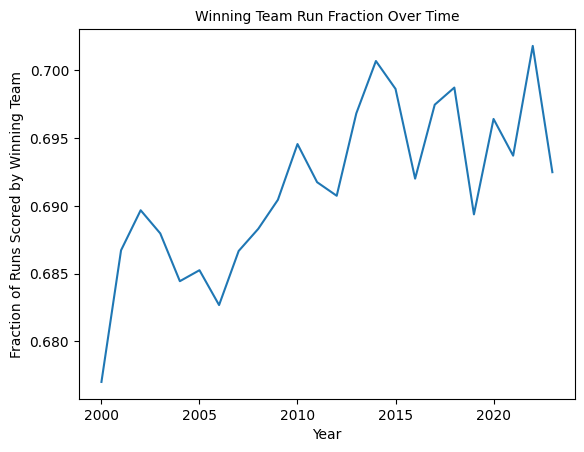

In [17]:
tdf = rundata[['season','wl']].groupby('season').mean()

plt.plot(tdf.wl)
plt.xlabel("Year")
plt.ylabel("Fraction of Runs Scored by Winning Team")
plt.title("Winning Team Run Fraction Over Time", fontsize=10)
plt.savefig("winfunfrac_year.png",dpi=200)

### Which run in a game best predicts the winner of the game?

Start by looking at the winning percentage of teams that score the Nth run of a game.

Text(0.5, 1.0, 'Which Run in Game Best Predicts Winner?')

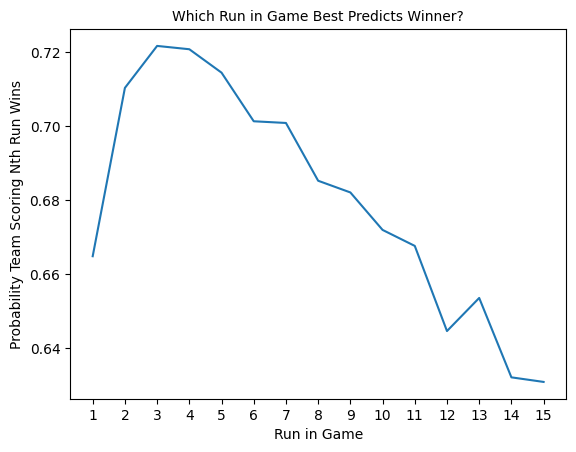

In [18]:
tdf = rundata[rundata.rig <= 15][['rig','wl']].groupby('rig').mean().reset_index()

plt.plot(tdf.rig,tdf.wl)
t = plt.xticks(np.arange(0,15)+1)
plt.xlabel("Run in Game")
plt.ylabel("Probability Team Scoring Nth Run Wins")
plt.title("Which Run in Game Best Predicts Winner?", fontsize=10)

In [19]:
tdf.head(5)

,rig,wl
0,1,0.664852
1,2,0.710393
2,3,0.721750
3,4,0.720852
4,5,0.714519


### Accounting for fact that not every game has an Nth run

One advantage of trying to predict the winner of a game based on who scores first is that every game with a winner has a team that scored first. However not every game has a 2nd, 3rd, ... or Nth run. So what happens if you consider games where the was no Nth run as a failed prediction?

Text(0, 0.5, 'Fraction of Games with an Nth Run')

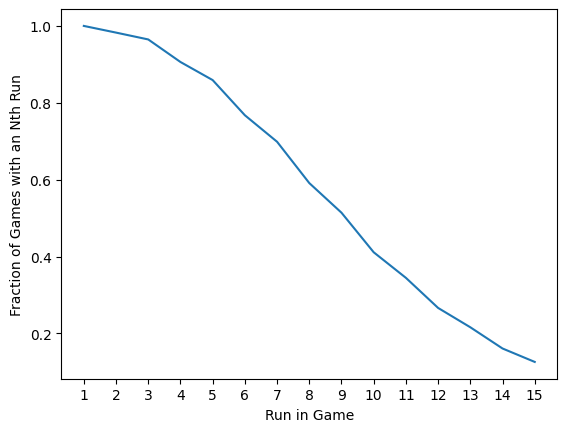

In [20]:
tdf = rundata[rundata.rig <= 15][['rig','wl']].groupby('rig').count().reset_index()
tdf['wlp'] = tdf['wl'] / ngames
plt.plot(tdf.rig,tdf.wlp)
t = plt.xticks(np.arange(0,15)+1)
plt.xlabel("Run in Game")
plt.ylabel("Fraction of Games with an Nth Run")


Text(0.5, 1.0, 'Which Run in Game Best Predicts Winner?')

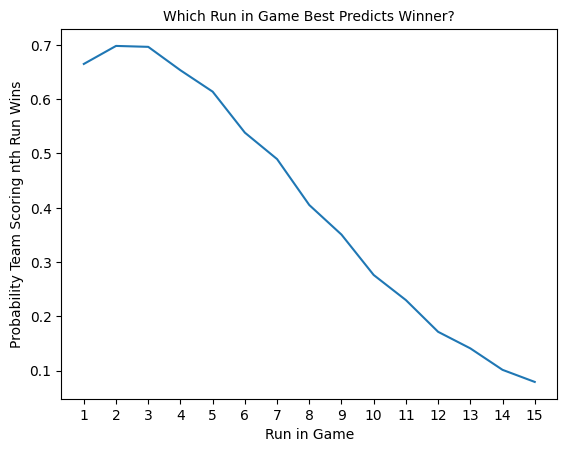

In [21]:
ngames = len(rs_gls)

tdf = rundata[rundata.rig <= 15][['rig','wl']].groupby('rig').sum().reset_index()
tdf['wlp'] = tdf['wl'] / ngames
plt.plot(tdf.rig,tdf.wlp)
t = plt.xticks(np.arange(0,15)+1)
plt.xlabel("Run in Game")
plt.ylabel("Probability Team Scoring nth Run Wins")
plt.title("Which Run in Game Best Predicts Winner?", fontsize=10)

In [22]:
tdf.head(5)

,rig,wl,wlp
0,1,37493,0.664852
1,2,39365,0.698048
2,3,39269,0.696345
3,4,36837,0.653219
4,5,34617,0.613853


### Has probability team scoring first run wins changed over time?

Text(0, 0.5, 'Fraction of times team scoring first won')

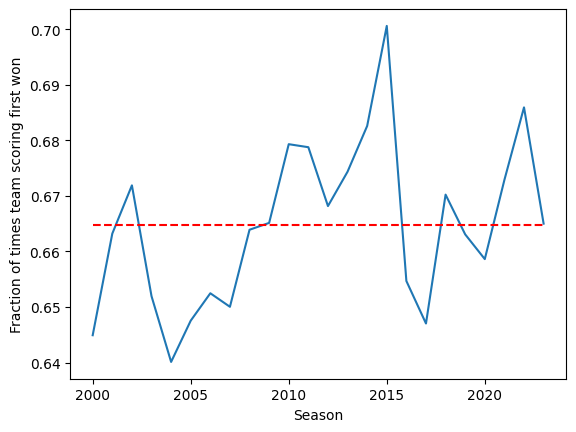

In [23]:
pfirstw = len(rundata[(rundata.rig == 1) & (rundata.wl == 1)]) / len(rundata[rundata.rig == 1])

plt.plot(rundata[rundata.rig == 1][['season','wl']].groupby('season').mean())
plt.plot([2000,2023],[pfirstw,pfirstw], '--', color='red')
plt.xlabel("Season")
plt.ylabel("Fraction of times team scoring first won")

### How does probability first run wins break down by inning?

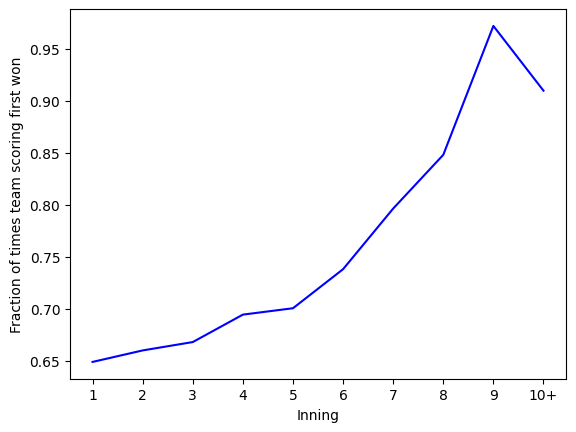

In [24]:
plt.plot(rundata[(rundata.rig == 1)][['inning_e','wl']].groupby('inning_e').mean(), label='away', color='blue')
plt.xlabel("Inning")
plt.ylabel("Fraction of times team scoring first won")
plt.xticks([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,"10+"])
print ()

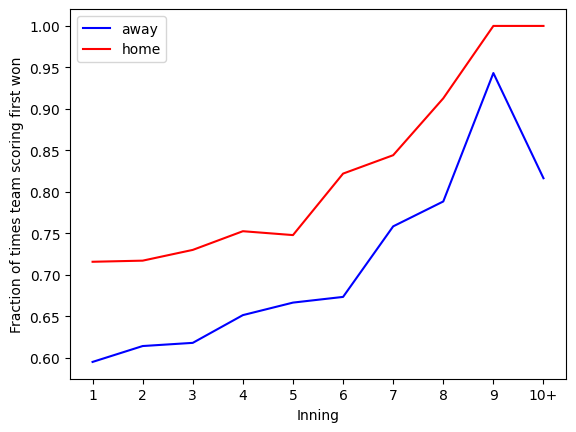

In [25]:
plt.plot(rundata[(rundata.team == 0) & (rundata.rig == 1)][['inning_e','wl']].groupby('inning_e').mean(), label='away', color='blue')
plt.plot(rundata[(rundata.team == 1) & (rundata.rig == 1)][['inning_e','wl']].groupby('inning_e').mean(), label='home', color='red')
plt.xlabel("Inning")
plt.ylabel("Fraction of times team scoring first won")
plt.xticks([1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,"10+"])
plt.legend()

### Which team scores Nth run?

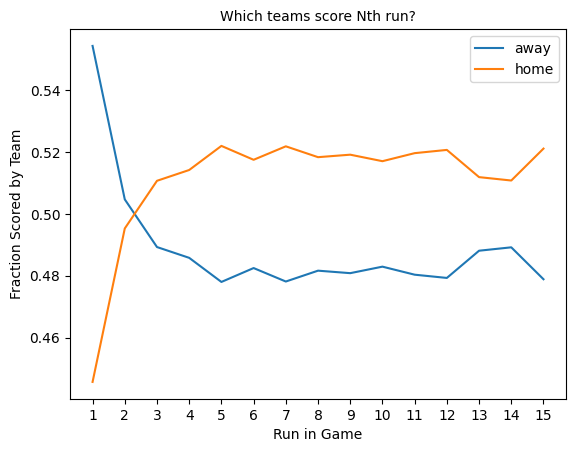

In [26]:
tdf = rundata[rundata.rig <= 15][['rig','team']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,1-tdf.team,label="away")
plt.plot(tdf.rig,tdf.team,label="home")
t = plt.xticks(tdf.rig.values)
plt.xlabel("Run in Game")
plt.ylabel("Fraction Scored by Team")
plt.title("Which teams score Nth run?",fontsize=10)
plt.legend()

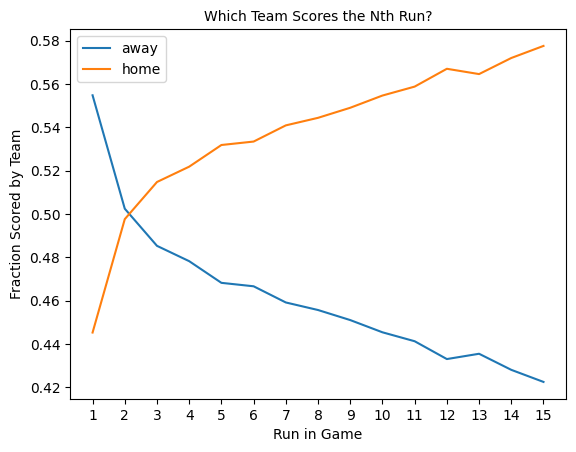

In [27]:
tdf = rundata[(rundata.inning < 9) & (rundata.rig <= 15)][['rig','team']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,1-tdf.team,label="away")
plt.plot(tdf.rig,tdf.team,label="home")
t = plt.xticks(tdf.rig.values)
plt.xlabel("Run in Game")
plt.ylabel("Fraction Scored by Team")
plt.title("Which Team Scores the Nth Run?", fontsize=10)
plt.legend()

### Breaking down Nth Run <-> Winning by Team Scoring Run

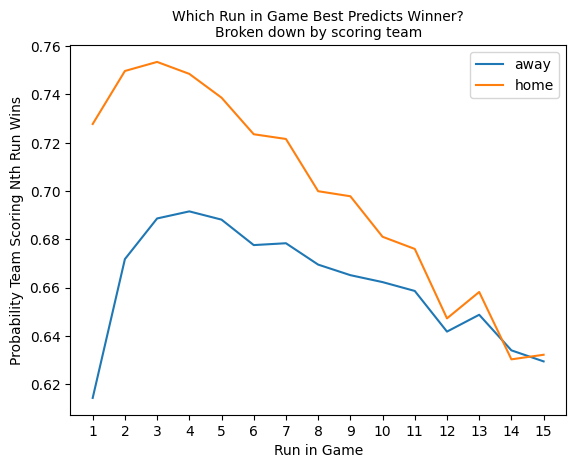

In [28]:
tdf = rundata[rundata.rig <= 15][['team','rig','wl']].groupby(['team','rig']).mean().reset_index()

tdfp = tdf[tdf.team == 0]
plt.plot(tdfp.rig,tdfp.wl,label='away')
tdfp = tdf[tdf.team == 1]
plt.plot(tdfp.rig,tdfp.wl,label='home')
t = plt.xticks(np.arange(0,15)+1)
plt.xlabel("Run in Game")
plt.ylabel("Probability Team Scoring Nth Run Wins")
plt.title("Which Run in Game Best Predicts Winner?\nBroken down by scoring team", fontsize=10)
plt.legend()


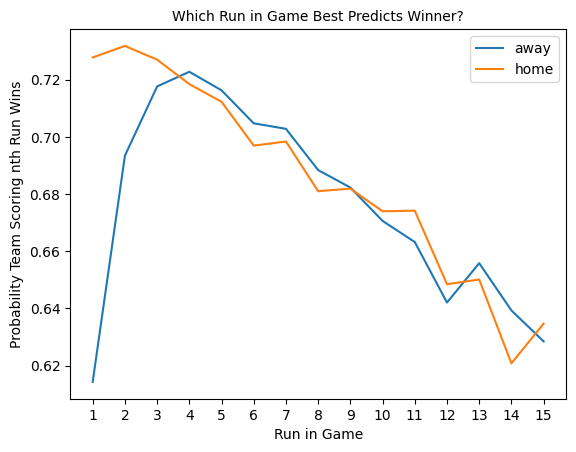

In [29]:
tdf1 = rundata[(rundata.fr == 0) & (rundata.rig <= 15)][['rig','wl']].groupby('rig').mean().reset_index()
plt.plot(tdf1.rig,tdf1.wl,label='away')
tdf2 = rundata[(rundata.fr == 1) & (rundata.rig <= 15)][['rig','wl']].groupby('rig').mean().reset_index()
plt.plot(tdf2.rig,tdf2.wl,label='home')

t = plt.xticks(np.arange(0,15)+1)
plt.xlabel("Run in Game")
plt.ylabel("Probability Team Scoring nth Run Wins")
plt.title("Which Run in Game Best Predicts Winner?", fontsize=10)
plt.legend()

### Breaking it down further by whether Nth run is scored by same or different team as 1st

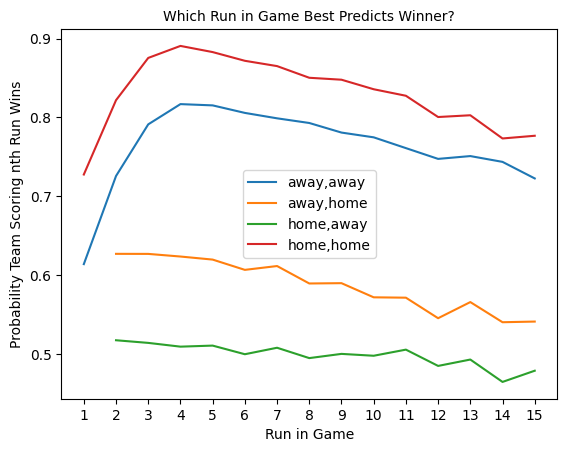

In [30]:
tdf = rundata[(rundata.fr == 0) & (rundata.team == 0) & (rundata.rig <= 15)][['rig','wl']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,tdf.wl,label='away,away')
tdf = rundata[(rundata.fr == 0) & (rundata.team == 1) & (rundata.rig <= 15)][['rig','wl']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,tdf.wl,label='away,home')
tdf = rundata[(rundata.fr == 1) & (rundata.team == 0) & (rundata.rig <= 15)][['rig','wl']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,tdf.wl,label='home,away')
tdf = rundata[(rundata.fr == 1) & (rundata.team == 1) & (rundata.rig <= 15)][['rig','wl']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,tdf.wl,label='home,home')

t = plt.xticks(np.arange(0,15)+1)
plt.xlabel("Run in Game")
plt.ylabel("Probability Team Scoring nth Run Wins")
plt.title("Which Run in Game Best Predicts Winner?", fontsize=10)
plt.legend()
plt.savefig("winfrac_rig.png",dpi=200)

### How Are Scoring 1st and Nth Runs Related?

In [31]:
### indicator variable for whether run was scored by same team as 1st run

rundata['frrig'] = rundata['fr'] == rundata['team']

Text(0.5, 1.0, 'How Are Scoring 1st and Nth Runs Related?')

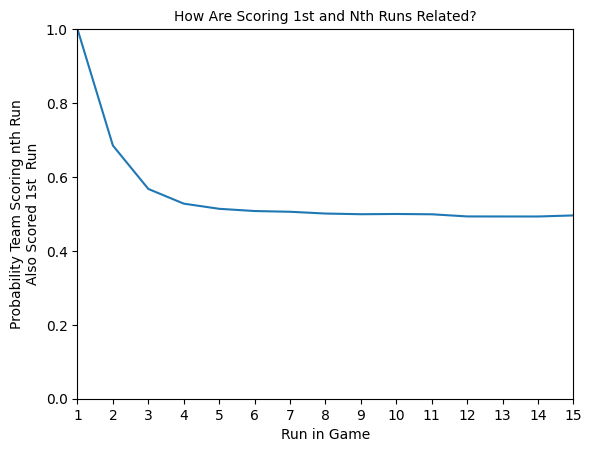

In [32]:
tdf = rundata[['rig','frrig']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,tdf.frrig)


t = plt.xticks(np.arange(0,15)+1)
plt.xlabel("Run in Game")
plt.ylabel("Probability Team Scoring nth Run\nAlso Scored 1st  Run")
plt.ylim(0,1)
plt.xlim(1,15)
plt.title("How Are Scoring 1st and Nth Runs Related?", fontsize=10)

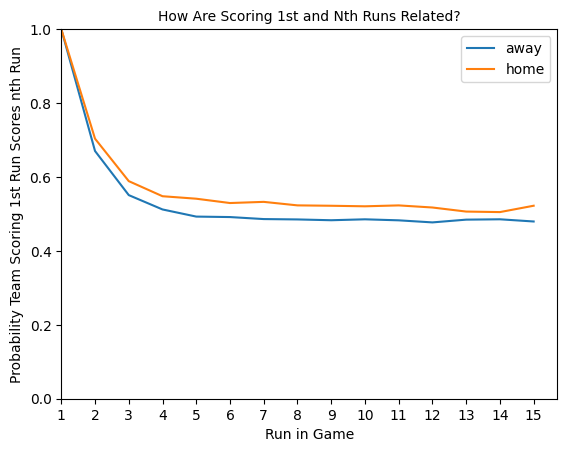

In [33]:
tdf1 = rundata[(rundata.fr == 0) & (rundata.rig <= 15)][['rig','wl','team']].groupby('rig').mean().reset_index()
plt.plot(tdf1.rig,1-tdf1.team,label='away')
tdf2 = rundata[(rundata.fr == 1) & (rundata.rig <= 15)][['rig','wl','team']].groupby('rig').mean().reset_index()
plt.plot(tdf2.rig,tdf2.team,label='home')
#tdf1 = rundata[ (rundata.rig <= 15)][['rig','wl']].groupby('rig').mean().reset_index()
#plt.plot(tdf1.rig,tdf1.wl,label='both')


t = plt.xticks(np.arange(0,15)+1)
plt.xlabel("Run in Game")
plt.ylabel("Probability Team Scoring 1st Run Scores nth Run")
plt.ylim(0,1)
plt.xlim(1,)
plt.title("How Are Scoring 1st and Nth Runs Related?", fontsize=10)
plt.legend()

In [36]:
rundata['rsgs'] = (rundata['team'] == 0) * rundata['vgs'] + (rundata['team'] == 1) * rundata['hgs']
rundata['nrsgs'] = (rundata['team'] == 1) * rundata['vgs'] + (rundata['team'] == 0) * rundata['hgs']

tdf = rundata[['rig','team','rsgs','nrsgs']].groupby(['rig','team']).mean().reset_index()
tdf = tdf[tdf.rig <=15]

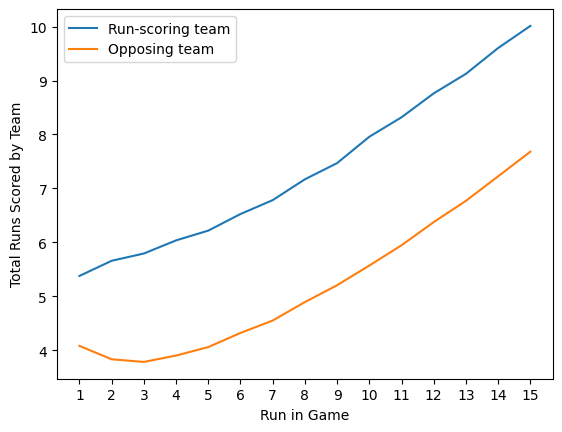

In [37]:
tdft = tdf[tdf.team == 0]
plt.plot(tdft.rig,tdft.rsgs,label="Run-scoring team")
plt.plot(tdft.rig,tdft.nrsgs,label="Opposing team")
plt.xticks(np.arange(1,16))
plt.xlabel("Run in Game")
plt.ylabel("Total Runs Scored by Team")
plt.legend()


### What about if we look at whether Nth run was decisive?

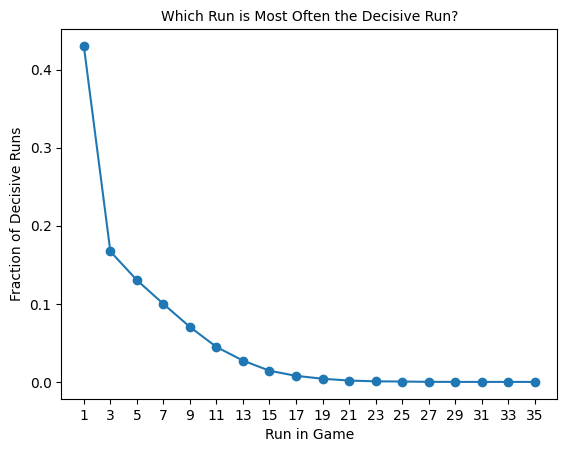

In [38]:
dr = rundata[rundata.rig == rundata.dr]

data = []
drcount = Counter(dr.rig)
for c in drcount:
  data.append([c,drcount[c]])

drc = pd.DataFrame(data=data,columns=['rig','dec']).sort_values('rig')
drc['drf'] = drc['dec'] / np.sum(drc.dec)

plt.plot(drc.rig,drc.drf)
plt.scatter(drc.rig,drc.drf)
t = plt.xticks(np.arange(1,37,2))
plt.xlabel("Run in Game")
plt.ylabel("Fraction of Decisive Runs")
plt.title("Which Run is Most Often the Decisive Run?",fontsize=10)
plt.savefig("fdec_rig.png",dpi=200)

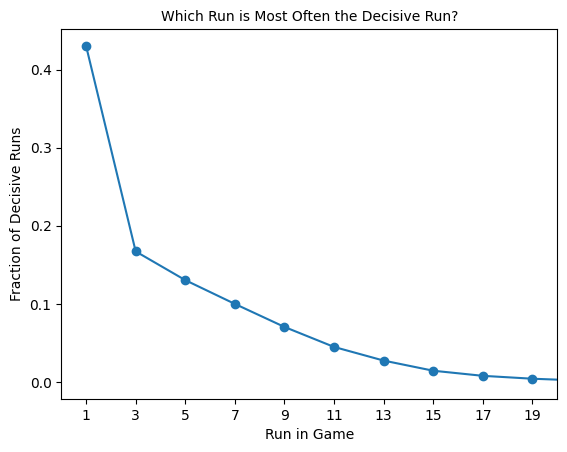

In [39]:
dr = rundata[rundata.rig == rundata.dr]

data = []
drcount = Counter(dr.rig)
for c in drcount:
  data.append([c,drcount[c]])

drc = pd.DataFrame(data=data,columns=['rig','dec']).sort_values('rig')
drc['drf'] = drc['dec'] / np.sum(drc.dec)

plt.plot(drc.rig,drc.drf)
plt.scatter(drc.rig,drc.drf)
t = plt.xticks(np.arange(1,21,2))
plt.xlim(0,20)
plt.xlabel("Run in Game")
plt.ylabel("Fraction of Decisive Runs")
plt.title("Which Run is Most Often the Decisive Run?",fontsize=10)
plt.savefig("fdec_rig.png",dpi=200)

In [40]:
rundata['isdec'] = rundata.rig == rundata.dr

Text(0, 0.5, 'Fraction of Games where 1st Run Decisive')

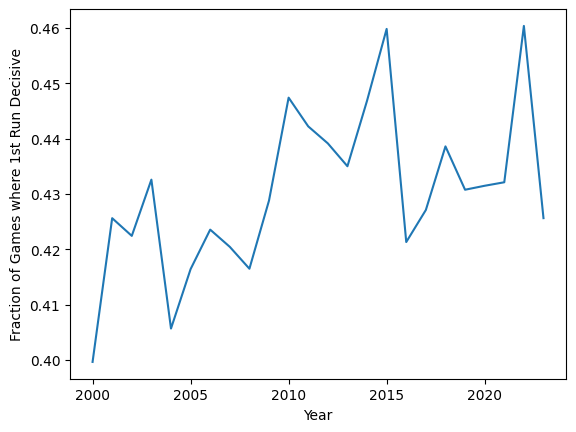

In [41]:
plt.plot(rundata[rundata.rig == 1][['season','isdec']].groupby('season').mean())
plt.xlabel('Year')
plt.ylabel("Fraction of Games where 1st Run Decisive")

Text(0, 0.5, 'Games where Decisive Run Scored in Inning')

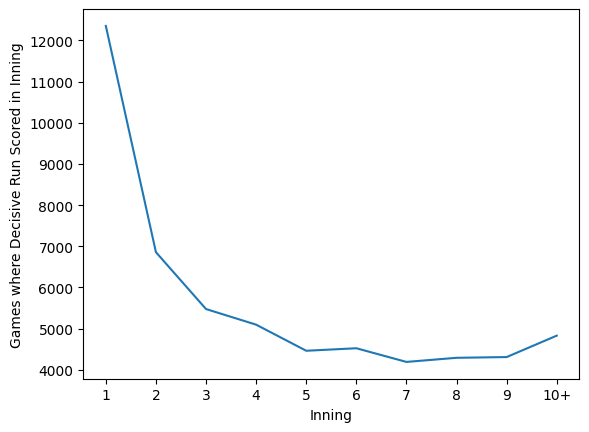

In [42]:
c = Counter(rundata[rundata.rig == rundata.dr].inning_e)
df = pd.DataFrame.from_dict(c, orient='index').reset_index()
df.columns = ['inning','drcount']
df = df.sort_values('inning')
plt.plot(df.inning,df.drcount)
plt.xticks([1,2,3,4,5,6,7,8,9,10],["1","2","3","4","5","6","7","8","9","10+"])
plt.xlabel("Inning")
plt.ylabel("Games where Decisive Run Scored in Inning")

### Was Nth run decisive conditioned on tie game

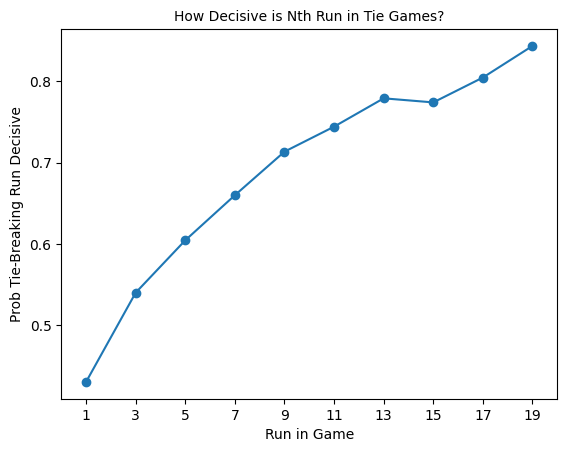

In [43]:
dr = rundata[rundata.leadb == 0][['rig','dr']].copy()
dr['drb'] = dr['rig'] == dr['dr']
drg = dr.groupby('rig').mean().reset_index()
drg = drg[drg.rig < 20]
plt.plot(drg.rig,drg.drb)
plt.scatter(drg.rig,drg.drb)
t = plt.xticks(np.arange(1,21,2))
plt.xlim(0,20)
plt.xlabel("Run in Game")
plt.ylabel("Prob Tie-Breaking Run Decisive")
plt.title("How Decisive is Nth Run in Tie Games?",fontsize=10)
plt.savefig("fdec_rig.png",dpi=200)

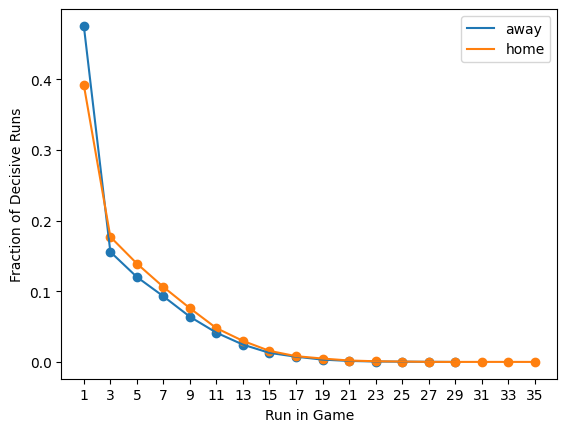

In [44]:
dr = rundata[rundata.rig == rundata.dr]

drt = dr[dr.team == 0]
data = []
drcount = Counter(drt.rig)
for c in drcount:
  data.append([c,drcount[c]])

drc = pd.DataFrame(data=data,columns=['rig','dec']).sort_values('rig')
drc['drf'] = drc['dec'] / np.sum(drc.dec)

plt.plot(drc.rig,drc.drf,label='away')
plt.scatter(drc.rig,drc.drf)

drt = dr[dr.team == 1]
data = []
drcount = Counter(drt.rig)
for c in drcount:
  data.append([c,drcount[c]])

drc = pd.DataFrame(data=data,columns=['rig','dec']).sort_values('rig')
drc['drf'] = drc['dec'] / np.sum(drc.dec)

plt.plot(drc.rig,drc.drf,label='home')
plt.scatter(drc.rig,drc.drf)

t = plt.xticks(np.arange(1,37,2))
plt.xlabel("Run in Game")
plt.ylabel("Fraction of Decisive Runs")
plt.savefig("fdec_rig.png",dpi=200)

plt.legend()

### Lead Before and After Run Scored

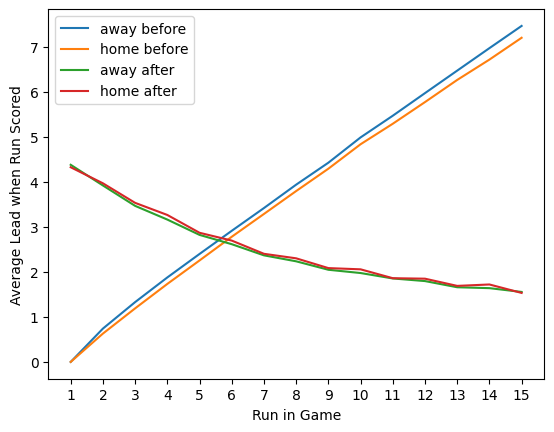

In [45]:
tdf = rundata[(rundata.rig <= 15) & (rundata.team == 0)][['rig','vrb']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,(tdf.vrb),label='away before')
tdf = rundata[(rundata.rig <= 15) & (rundata.team == 1)][['rig','hrb']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,(tdf.hrb),label='home before')
tdf = rundata[(rundata.rig <= 15) & (rundata.team == 0)][['rig','vrr']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,(tdf.vrr),label='away after')
tdf = rundata[(rundata.rig <= 15) & (rundata.team == 1)][['rig','hrr']].groupby('rig').mean().reset_index()
plt.plot(tdf.rig,(tdf.hrr),label='home after')


plt.xticks(np.arange(0,15)+1)
plt.xlabel("Run in Game")
plt.ylabel("Average Lead when Run Scored")
plt.legend()